In [1]:
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import h5py
import re
import pickle

from hest.vis.plot import *
from hest.vis.visualise_pred import *

In [2]:
RUN_ROOT = "/project/simmons_hts/kxu/hest/eval/ST_pred_results"
df_summary = summarize_runs(RUN_ROOT)
df_summary.to_csv("/project/simmons_hts/kxu/hest/eval/experiment_log.csv")
#display(df_summary)
best_df = best_results_by_gene_and_dataset(df_summary)
# Remove rows where dataset == "pilot" (case insensitive, just in case)
# best_df = best_df[best_df["dataset"].str.lower() != "pilot"].reset_index(drop=True)
best_df

,run,gene_list,num_genes,alpha,batch_size,dimreduce,encoders,normalize,library_size_normalize,latent_dim,method,dataset,best_model,highest_pearson_mean,highest_pearson_std,num_training_patches_mean
0,run_25-10-27-16-01-16,all_genes.json,5100,None,256,PCA,"hoptimus1, hoptimus0, virchow2, hibou_large, u...",True,False,256,ridge,XeniumPR,virchow2,0.483176,0.201268,NaN
1,run_25-09-09-11-50-04,all_genes.json,5100,None,128,PCA,"uni_v1, resnet50, ctranspath, phikon, phikon_v...",True,False,256,ridge,XeniumPR1,virchow2,0.510421,0.209865,NaN
2,run_25-12-04-15-00-11,all_genes.json,4842,None,512,PCA,"hoptimus1, hoptimus0, virchow2, hibou_large, u...",True,False,256,ridge,XeniumPR1-5_ex_val,uni_v2,0.240999,0.023834,NaN
3,run_25-10-23-19-25-27,all_genes.json,5100,None,512,PCA,"uni_v2, hoptimus1, virchow2, hoptimus0, gigapa...",True,False,256,ridge,XeniumPR1_25um_0.125_um_px,hibou_large,0.233654,0.146511,364309.866667
4,run_25-10-17-19-48-38,all_genes.json,5100,None,256,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large, u...",True,False,256,ridge,XeniumPR1_50um,hoptimus1,0.393534,0.198990,97647.200000
5,run_25-11-14-16-21-05,all_genes.json,5100,None,512,PCA,"gigapath, hoptimus0, hoptimus1, virchow2, hibo...",True,False,256,ridge,XeniumPR1_50um_0.25_um_px,hoptimus1,0.380217,0.195273,97647.200000
6,run_25-10-03-14-11-52,all_genes.json,312,None,256,PCA,"uni_v1, resnet50, ctranspath, phikon, phikon_v...",True,False,256,ridge,XeniumPR1_broad,virchow2,0.512409,0.050549,31821.697479
7,run_25-10-02-20-20-51,all_genes.json,5100,None,256,PCA,"uni_v1, resnet50, ctranspath, phikon, phikon_v...",True,False,256,ridge,XeniumPR1_segger,virchow2,0.507104,0.209986,22598.235294
8,run_25-10-24-16-11-47,all_genes.json,5100,None,512,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large, u...",True,False,256,ridge,XeniumPR2,virchow2,0.391768,0.202134,NaN
9,run_25-10-27-18-43-26,all_genes.json,5100,None,256,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large",True,False,256,ridge,XeniumPR3,virchow2,0.391768,0.202134,NaN


# use wrapper function to add pred to adata, save adata & plot specified genes

don't do for non segger Xenium as adata is for the whole slide (too large to plot)

In [3]:
# broad cell centered dataset -> does not work since no spatial coordinates
# RUN = 'run_25-09-24-17-32-01'
# RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

# results = add_inference_to_adata_and_plot(
#     RUN=RUN,
#     RUN_ROOT=RUN_ROOT,
#     dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
#     gene_lists_to_plot={
#         "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
#         "conditional_genes": ("XeniumPR1", "conditional_genes.json")
#     },
#     verbose=True
# )

In [4]:
# broad dataset
RUN = 'run_25-09-20-19-30-20'
RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

results = add_inference_to_adata_and_plot(
    RUN=RUN,
    RUN_ROOT=RUN_ROOT,
    dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
    gene_lists_to_plot={
        "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
        "conditional_genes": ("XeniumPR1", "conditional_genes.json")
    },
    verbose=True
)

[step] extract best model corrs
[extract] dataset=broad encoder=hoptimus0 pearson_mean=0.6741391990143638 std=0.031085748995757997
[step] load best model inference and metadata
Best model for dataset broad:
encoder_name: hoptimus0
pearson_mean: 0.6741391990143638
pearson_std: 0.031085748995757997
Genes predicted from list: all_genes.json
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split3
Loaded inference_dump.pkl from split2
Loaded inference_dump.pkl from split4
Loaded inference_dump.pkl from split1
[info] using dataset_name = broad
[step] load gene list used to format inference
Loaded all_genes.json for dataset 'broad'
[step] format inference with gene list
split0: preds shape (5644, 460), targets shape (5644, 460)
split3: preds shape (3607, 460), targets shape (3607, 460)
split2: preds shape (11778, 460), targets shape (11778, 460)
split4: preds shape (7335, 460), targets shape (7335, 460)
split1: preds shape (11067, 460), targets shape (11067, 460)
[step] re

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC6_NI.pdf
[START] Writing PDF for adata_list[2] (UC1_I) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC1_I.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC1_I.pdf
[START] Writing PDF for adata_list[3] (UC9_I) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC9_I.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC9_I.pdf
[START] Writing PDF for adata_list[4] (UC6_I) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/pred/conditional_genes/UC6_I.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-20-19-30-20/plots/p

In [4]:
RUN = 'run_25-10-27-16-11-18'
RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

results = add_inference_to_adata_and_plot(
    RUN=RUN,
    RUN_ROOT=RUN_ROOT,
    dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
    gene_lists_to_plot={
        "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
        "conditional_genes": ("XeniumPR1", "conditional_genes.json")
    },
    verbose=True
)

[step] extract best model corrs
[extract] dataset=XeniumPR3 encoder=virchow2 pearson_mean=0.5511947205490406 std=0.13300310788067127
[step] load best model inference and metadata
Best model for dataset XeniumPR3:
encoder_name: virchow2
pearson_mean: 0.5511947205490406
pearson_std: 0.13300310788067127
Genes predicted from list: common_genes_0.1.json
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split3
Loaded inference_dump.pkl from split5
Loaded inference_dump.pkl from split2
Loaded inference_dump.pkl from split4
Loaded inference_dump.pkl from split7
Loaded inference_dump.pkl from split6
Loaded inference_dump.pkl from split1
[info] using dataset_name = XeniumPR3
[step] load gene list used to format inference
Loaded common_genes_0.1.json for dataset 'XeniumPR3'
[step] format inference with gene list
split0: preds shape (2625, 2172), targets shape (2625, 2172)
split3: preds shape (2045, 2172), targets shape (2045, 2172)
split5: preds shape (2054, 2172), targets shap

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes/XeniumPR3S1ROI1.pdf
[START] Writing PDF for adata_list[6] (XeniumPR3S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes/XeniumPR3S1ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes/XeniumPR3S1ROI3.pdf
[START] Writing PDF for adata_list[7] (XeniumPR3S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes/XeniumPR3S1ROI8.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes/XeniumPR3S1ROI8.pdf
[DONE] saved PDFs to /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-27-16-11-18/plots/pred/cell_specific_genes
Loaded conditional_genes.json for dataset 'XeniumPR1'
[plot] crea

In [ ]:
RUN = 'run_25-11-21-17-06-15'
RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

results = add_inference_to_adata_and_plot(
    RUN=RUN,
    RUN_ROOT=RUN_ROOT,
    dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
    gene_lists_to_plot={
        "coeliac_genes": ("XeniumPR1", "coeliac_genes.json"),
        "tcr_genes": ("XeniumPR1", "tcr_genes.json"),
        "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
        "conditional_genes": ("XeniumPR1", "conditional_genes.json")
    },
    verbose=True
)

[step] extract best model corrs
[extract] dataset=XeniumPR4-5 encoder=hoptimus1 pearson_mean=0.4184170827150864 std=0.2498835148261378
[step] load best model inference and metadata
Best model for dataset XeniumPR4-5:
encoder_name: hoptimus1
pearson_mean: 0.4184170827150864
pearson_std: 0.2498835148261378
Genes predicted from list: all_genes.json
Loaded inference_dump.pkl from split15
Loaded inference_dump.pkl from split9
Loaded inference_dump.pkl from split10
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split3
Loaded inference_dump.pkl from split5
Loaded inference_dump.pkl from split2
Loaded inference_dump.pkl from split12
Loaded inference_dump.pkl from split4
Loaded inference_dump.pkl from split7
Loaded inference_dump.pkl from split19
Loaded inference_dump.pkl from split6
Loaded inference_dump.pkl from split16
Loaded inference_dump.pkl from split1
Loaded inference_dump.pkl from split18
Loaded inference_dump.pkl from split13
Loaded inference_dump.pkl from split2

  -> XeniumPR5S2ROI8: rows 0:431 (431)
  -> XeniumPR5S2ROI5: rows 431:1297 (866)
[info] splitting split19 (1547 rows) into samples: ['XeniumPR5S2ROI9', 'XeniumPR5S1ROI8']
  -> XeniumPR5S2ROI9: rows 0:581 (581)
  -> XeniumPR5S1ROI8: rows 581:1547 (966)
[info] splitting split6 (1166 rows) into samples: ['XeniumPR4S1ROI1', 'XeniumPR5S1ROI7']
  -> XeniumPR4S1ROI1: rows 0:796 (796)
  -> XeniumPR5S1ROI7: rows 796:1166 (370)
[info] splitting split16 (1120 rows) into samples: ['XeniumPR4S2ROI10', 'XeniumPR4S1ROI7']
  -> XeniumPR4S2ROI10: rows 0:395 (395)
  -> XeniumPR4S1ROI7: rows 395:1120 (725)
[info] splitting split1 (1356 rows) into samples: ['XeniumPR4S1ROI3', 'XeniumPR5S1ROI10']
  -> XeniumPR4S1ROI3: rows 0:716 (716)
  -> XeniumPR5S1ROI10: rows 716:1356 (640)
[info] splitting split18 (1396 rows) into samples: ['XeniumPR4S1ROI8', 'XeniumPR4S2ROI4']
  -> XeniumPR4S1ROI8: rows 0:605 (605)
  -> XeniumPR4S2ROI4: rows 605:1396 (791)
[info] splitting split13 (1144 rows) into samples: ['XeniumPR4

[OK] sample 'XeniumPR4S1ROI9' -> adata[19] | matched_barcodes=399/399 | common_genes=4891 | method=match_by_obs_names | spots_with_pred=399/1076 (37.08%)
[sanitize] ensuring adata_list[35] is h5ad-safe
[OK] sample 'XeniumPR5S1ROI2' -> adata[35] | matched_barcodes=218/218 | common_genes=4891 | method=match_by_obs_names | spots_with_pred=218/801 (27.22%)
[sanitize] ensuring adata_list[18] is h5ad-safe
[OK] sample 'XeniumPR4S1ROI4' -> adata[18] | matched_barcodes=730/730 | common_genes=4891 | method=match_by_obs_names | spots_with_pred=730/2203 (33.14%)
[sanitize] ensuring adata_list[16] is h5ad-safe
[OK] sample 'XeniumPR4S2ROI7' -> adata[16] | matched_barcodes=758/758 | common_genes=4891 | method=match_by_obs_names | spots_with_pred=758/1894 (40.02%)
[sanitize] ensuring adata_list[13] is h5ad-safe
[OK] sample 'XeniumPR4S2ROI3' -> adata[13] | matched_barcodes=716/716 | common_genes=4891 | method=match_by_obs_names | spots_with_pred=716/2380 (30.08%)
[sanitize] ensuring adata_list[12] is h

[OK] Saved XeniumPR5S2ROI1 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S2ROI1.h5ad
[OK] Saved XeniumPR5S2ROI6 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S2ROI6.h5ad
[OK] Saved XeniumPR4S1ROI6 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR4S1ROI6.h5ad
[OK] Saved XeniumPR5S1ROI9 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S1ROI9.h5ad
[OK] Saved XeniumPR5S1ROI7 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S1ROI7.h5ad
[OK] Saved XeniumPR5S2ROI9 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S2ROI9.h5ad
[OK] Saved XeniumPR5S1ROI1 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pred/XeniumPR5S1ROI1.h5ad
[OK] Saved XeniumPR5S1ROI4 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/pr

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI5.pdf
[START] Writing PDF for adata_list[18] (XeniumPR4S1ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI4.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI4.pdf
[START] Writing PDF for adata_list[19] (XeniumPR4S1ROI9) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI9.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI9.pdf
[START] Writing PDF for adata_list[20] (XeniumPR4S1ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/coeliac_genes/XeniumPR4S1ROI1.pdf (genes: 9)
[OK] Wrote PDF: /project/simmon

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR4S2ROI10.pdf
[START] Writing PDF for adata_list[2] (XeniumPR5S2ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI2.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI2.pdf
[START] Writing PDF for adata_list[3] (XeniumPR4S2ROI9) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR4S2ROI9.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR4S2ROI9.pdf
[START] Writing PDF for adata_list[4] (XeniumPR5S1ROI6) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S1ROI6.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pre

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S1ROI4.pdf
[START] Writing PDF for adata_list[29] (XeniumPR5S2ROI7) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI7.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI7.pdf
[START] Writing PDF for adata_list[30] (XeniumPR5S2ROI11) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI11.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR5S2ROI11.pdf
[START] Writing PDF for adata_list[31] (XeniumPR4S1ROI10) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/tcr_genes/XeniumPR4S1ROI10.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR5S2ROI8.pdf
[START] Writing PDF for adata_list[13] (XeniumPR4S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI3.pdf
[START] Writing PDF for adata_list[14] (XeniumPR4S2ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI2.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI2.pdf
[START] Writing PDF for adata_list[15] (XeniumPR4S1ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S1ROI2.pdf (gen

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR5S2ROI10.pdf
[START] Writing PDF for adata_list[38] (XeniumPR4S2ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI4.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR4S2ROI4.pdf
[START] Writing PDF for adata_list[39] (XeniumPR5S1ROI5) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR5S1ROI5.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR5S1ROI5.pdf
[START] Writing PDF for adata_list[40] (XeniumPR5S2ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/cell_specific_genes/XeniumPR5S2ROI4.pdf (ge

/home/k/kxu/.local/lib/python3.11/site-packages/hest/vis/visualise_pred.py:1078: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, _ = pearsonr(pred_vals[mask], target_vals[mask])


[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR4S1ROI9.pdf
[START] Writing PDF for adata_list[20] (XeniumPR4S1ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR4S1ROI1.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR4S1ROI1.pdf
[START] Writing PDF for adata_list[21] (XeniumPR5S2ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR5S2ROI1.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR5S2ROI1.pdf
[START] Writing PDF for adata_list[22] (XeniumPR5S2ROI6) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-11-21-17-06-15/plots/pred/conditional_genes/XeniumPR5S2ROI6.pdf (genes: 24)
[OK]

In [ ]:
# coeliac & cd 5k xenium external validation
RUN = 'run_25-12-04-15-00-11'
RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

results = add_inference_to_adata_and_plot(
    RUN=RUN,
    RUN_ROOT=RUN_ROOT,
    dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
    gene_lists_to_plot={
        "coeliac_genes": ("XeniumPR1", "coeliac_genes.json"),
        "tcr_genes": ("XeniumPR1", "tcr_genes.json"),
        "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
        "conditional_genes": ("XeniumPR1", "conditional_genes.json")
    },
    verbose=True
)

[step] extract best model corrs
[extract] dataset=XeniumPR1-5_ex_val encoder=uni_v2 pearson_mean=0.24099869390259085 std=0.023834396111455852
[step] load best model inference and metadata
Best model for dataset XeniumPR1-5_ex_val:
encoder_name: uni_v2
pearson_mean: 0.24099869390259085
pearson_std: 0.023834396111455852
Genes predicted from list: all_genes.json
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split1
[info] using dataset_name = XeniumPR1-5_ex_val
[step] load gene list used to format inference
Loaded all_genes.json for dataset 'XeniumPR1-5_ex_val'
[step] format inference with gene list
split0: preds shape (24559, 4842), targets shape (24559, 4842)
split1: preds shape (53096, 4842), targets shape (53096, 4842)
[step] remap split keys -> sample names using test splits
[step] loading adata files from /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-5_ex_val/adata
  loading /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-5_ex_val/adata/XeniumPR2S1ROI2.h5

  -> XeniumPR4S1ROI4: rows 2795:3525 (730)
  -> XeniumPR4S1ROI5: rows 3525:4002 (477)
  -> XeniumPR4S1ROI6: rows 4002:4441 (439)
  -> XeniumPR4S1ROI7: rows 4441:5166 (725)
  -> XeniumPR4S1ROI8: rows 5166:5771 (605)
  -> XeniumPR4S1ROI9: rows 5771:6170 (399)
  -> XeniumPR4S2ROI1: rows 6170:6721 (551)
  -> XeniumPR4S2ROI10: rows 6721:7116 (395)
  -> XeniumPR4S2ROI2: rows 7116:7723 (607)
  -> XeniumPR4S2ROI3: rows 7723:8439 (716)
  -> XeniumPR4S2ROI4: rows 8439:9230 (791)
  -> XeniumPR4S2ROI5: rows 9230:10090 (860)
  -> XeniumPR4S2ROI6: rows 10090:10868 (778)
  -> XeniumPR4S2ROI7: rows 10868:11626 (758)
  -> XeniumPR4S2ROI8: rows 11626:12058 (432)
  -> XeniumPR4S2ROI9: rows 12058:12572 (514)
  -> XeniumPR5S1ROI1: rows 12572:13007 (435)
  -> XeniumPR5S1ROI10: rows 13007:13647 (640)
  -> XeniumPR5S1ROI2: rows 13647:13865 (218)
  -> XeniumPR5S1ROI3: rows 13865:14504 (639)
  -> XeniumPR5S1ROI4: rows 14504:15056 (552)
  -> XeniumPR5S1ROI5: rows 15056:15721 (665)
  -> XeniumPR5S1ROI6: rows 1572

[read] XeniumPR1S2ROI4.h5: 2674 barcodes
[ok] XeniumPR1S2ROI4: attached 2674 barcodes
[read] XeniumPR1S2ROI5.h5: 892 barcodes
[ok] XeniumPR1S2ROI5: attached 892 barcodes
[read] XeniumPR1S2ROI6.h5: 1631 barcodes
[ok] XeniumPR1S2ROI6: attached 1631 barcodes
[read] XeniumPR1S2ROI7.h5: 1868 barcodes
[ok] XeniumPR1S2ROI7: attached 1868 barcodes
[read] XeniumPR2S1ROI1.h5: 2850 barcodes
[ok] XeniumPR2S1ROI1: attached 2850 barcodes
[read] XeniumPR2S1ROI2.h5: 2352 barcodes
[ok] XeniumPR2S1ROI2: attached 2352 barcodes
[read] XeniumPR2S1ROI3.h5: 1597 barcodes
[ok] XeniumPR2S1ROI3: attached 1597 barcodes
[read] XeniumPR2S1ROI4.h5: 1592 barcodes
[ok] XeniumPR2S1ROI4: attached 1592 barcodes
[read] XeniumPR2S1ROI5.h5: 2725 barcodes
[ok] XeniumPR2S1ROI5: attached 2725 barcodes
[read] XeniumPR2S1ROI6.h5: 720 barcodes
[ok] XeniumPR2S1ROI6: attached 720 barcodes
[read] XeniumPR2S1ROI7.h5: 565 barcodes
[ok] XeniumPR2S1ROI7: attached 565 barcodes
[read] XeniumPR2S1ROI8.h5: 1362 barcodes
[ok] XeniumPR2S1ROI

[OK] sample 'XeniumPR5S2ROI11' -> adata[56] | matched_barcodes=703/703 | common_genes=4842 | method=match_by_obs_names | spots_with_pred=703/1500 (46.87%)
[sanitize] ensuring adata_list[4] is h5ad-safe
[OK] sample 'XeniumPR5S2ROI2' -> adata[4] | matched_barcodes=340/340 | common_genes=4842 | method=match_by_obs_names | spots_with_pred=340/1508 (22.55%)
[sanitize] ensuring adata_list[10] is h5ad-safe
[OK] sample 'XeniumPR5S2ROI3' -> adata[10] | matched_barcodes=440/440 | common_genes=4842 | method=match_by_obs_names | spots_with_pred=440/1405 (31.32%)
[sanitize] ensuring adata_list[70] is h5ad-safe
[OK] sample 'XeniumPR5S2ROI4' -> adata[70] | matched_barcodes=706/706 | common_genes=4842 | method=match_by_obs_names | spots_with_pred=706/1670 (42.28%)
[sanitize] ensuring adata_list[1] is h5ad-safe
[OK] sample 'XeniumPR5S2ROI5' -> adata[1] | matched_barcodes=866/866 | common_genes=4842 | method=match_by_obs_names | spots_with_pred=866/2920 (29.66%)
[sanitize] ensuring adata_list[36] is h5a

[OK] Saved XeniumPR4S2ROI10 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR4S2ROI10.h5ad
[OK] Saved XeniumPR3S1ROI7 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR3S1ROI7.h5ad
[OK] Saved XeniumPR5S2ROI2 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR5S2ROI2.h5ad
[OK] Saved XeniumPR4S2ROI9 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR4S2ROI9.h5ad
[OK] Saved XeniumPR5S1ROI6 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR5S1ROI6.h5ad
[OK] Saved XeniumPR4S1ROI8 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR4S1ROI8.h5ad
[OK] Saved XeniumPR4S2ROI8 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR4S2ROI8.h5ad
[OK] Saved XeniumPR1S1ROI8 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/

[OK] Saved XeniumPR5S2ROI10 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR5S2ROI10.h5ad
[OK] Saved XeniumPR2S1ROI8 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR2S1ROI8.h5ad
[OK] Saved XeniumPR4S2ROI4 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR4S2ROI4.h5ad
[OK] Saved XeniumPR5S1ROI5 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR5S1ROI5.h5ad
[OK] Saved XeniumPR5S2ROI4 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR5S2ROI4.h5ad
[OK] Saved XeniumPR2S1ROI1 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred/XeniumPR2S1ROI1.h5ad
All AnnData objects saved under /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/pred
Loaded coeliac_genes.json for dataset 'XeniumPR1'
[plot] creating pdfs for gene list 'coeliac_genes' with 9 genes
[START

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR3S1ROI4.pdf
[START] Writing PDF for adata_list[23] (XeniumPR2S1ROI7) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR2S1ROI7.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR2S1ROI7.pdf
[START] Writing PDF for adata_list[24] (XeniumPR1S2ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR1S2ROI2.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR1S2ROI2.pdf
[START] Writing PDF for adata_list[25] (XeniumPR4S1ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR4S1ROI2.pdf (genes: 9)
[OK] Wrote PDF: /project/simmon

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR5S2ROI9.pdf
[START] Writing PDF for adata_list[49] (XeniumPR1S2ROI6) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR1S2ROI6.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR1S2ROI6.pdf
[START] Writing PDF for adata_list[50] (XeniumPR5S1ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR5S1ROI1.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR5S1ROI1.pdf
[START] Writing PDF for adata_list[51] (XeniumPR5S1ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/coeliac_genes/XeniumPR5S1ROI4.pdf (genes: 9)
[OK] Wrote PDF: /project/simmon

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR5S2ROI5.pdf
[START] Writing PDF for adata_list[2] (XeniumPR4S2ROI10) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S2ROI10.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S2ROI10.pdf
[START] Writing PDF for adata_list[3] (XeniumPR3S1ROI7) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR3S1ROI7.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR3S1ROI7.pdf
[START] Writing PDF for adata_list[4] (XeniumPR5S2ROI2) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR5S2ROI2.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_p

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S1ROI5.pdf
[START] Writing PDF for adata_list[29] (XeniumPR1S1ROI5) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR1S1ROI5.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR1S1ROI5.pdf
[START] Writing PDF for adata_list[30] (XeniumPR1S1ROI7) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR1S1ROI7.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR1S1ROI7.pdf
[START] Writing PDF for adata_list[31] (XeniumPR4S1ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S1ROI4.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_p

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR3S1ROI8.pdf
[START] Writing PDF for adata_list[56] (XeniumPR5S2ROI11) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR5S2ROI11.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR5S2ROI11.pdf
[START] Writing PDF for adata_list[57] (XeniumPR4S1ROI10) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S1ROI10.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S1ROI10.pdf
[START] Writing PDF for adata_list[58] (XeniumPR4S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/tcr_genes/XeniumPR4S1ROI3.pdf (genes: 9)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eva

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S2ROI8.pdf
[START] Writing PDF for adata_list[9] (XeniumPR1S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf
[START] Writing PDF for adata_list[10] (XeniumPR5S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S2ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S2ROI3.pdf
[START] Writing PDF for adata_list[11] (XeniumPR4S2ROI5) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S2ROI5.pdf (gene

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S1ROI1.pdf
[START] Writing PDF for adata_list[34] (XeniumPR5S2ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S2ROI1.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S2ROI1.pdf
[START] Writing PDF for adata_list[35] (XeniumPR1S1ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR1S1ROI4.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR1S1ROI4.pdf
[START] Writing PDF for adata_list[36] (XeniumPR5S2ROI6) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S2ROI6.pdf (gen

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S1ROI3.pdf
[START] Writing PDF for adata_list[59] (XeniumPR5S1ROI10) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S1ROI10.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR5S1ROI10.pdf
[START] Writing PDF for adata_list[60] (XeniumPR4S2ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S2ROI1.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR4S2ROI1.pdf
[START] Writing PDF for adata_list[61] (XeniumPR2S1ROI5) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/cell_specific_genes/XeniumPR2S1ROI5.pdf (

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S2ROI3.pdf
[START] Writing PDF for adata_list[11] (XeniumPR4S2ROI5) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S2ROI5.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S2ROI5.pdf
[START] Writing PDF for adata_list[12] (XeniumPR5S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S1ROI8.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S1ROI8.pdf
[START] Writing PDF for adata_list[13] (XeniumPR4S1ROI7) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI7.pdf (genes: 24)
[OK]

/home/k/kxu/.local/lib/python3.11/site-packages/hest/vis/visualise_pred.py:1078: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_val, _ = pearsonr(pred_vals[mask], target_vals[mask])


[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI9.pdf
[START] Writing PDF for adata_list[33] (XeniumPR4S1ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI1.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI1.pdf
[START] Writing PDF for adata_list[34] (XeniumPR5S2ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S2ROI1.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S2ROI1.pdf
[START] Writing PDF for adata_list[35] (XeniumPR1S1ROI4) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR1S1ROI4.pdf (genes: 24)
[OK]

[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI10.pdf
[START] Writing PDF for adata_list[58] (XeniumPR4S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI3.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S1ROI3.pdf
[START] Writing PDF for adata_list[59] (XeniumPR5S1ROI10) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S1ROI10.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR5S1ROI10.pdf
[START] Writing PDF for adata_list[60] (XeniumPR4S2ROI1) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-12-04-15-00-11/plots/pred/conditional_genes/XeniumPR4S2ROI1.pdf (genes: 24)


# Step breakdown in wrapper

## Get Predicted Gene Values

In [5]:
RUN = 'run_25-09-20-19-30-20'
print("Selected RUNS:", RUN)

best_model, dataset, df_corr = extract_best_model_gene_corrs(RUN)

Selected RUNS: run_25-09-20-19-30-20
[extract] dataset=broad encoder=hoptimus0 pearson_mean=0.6741391990143638 std=0.031085748995757997


In [6]:
df_corr

,gene,mean_corr,std_corr,corr_per_split
0,HNF4A,0.951206,0.01094,"[0.9516268261612305, 0.9490362082191294, 0.932..."
1,TPM2,0.945601,0.013173,"[0.9537817323182844, 0.9212166376053319, 0.943..."
2,NXPE1,0.941795,0.011617,"[0.9470189863187621, 0.9324609545089294, 0.924..."
3,CDHR5,0.941578,0.014599,"[0.9552542536298556, 0.9429871207996551, 0.930..."
4,DES,0.941483,0.016533,"[0.9579594305205154, 0.9198447681093674, 0.934..."
...,...,...,...,...
455,RNASE2,0.229222,0.122927,"[0.10664615040283033, 0.45054633082292456, 0.1..."
456,CCR3,0.218329,0.09032,"[0.12346987544426506, 0.3061221044483454, 0.26..."
457,PGLYRP1,0.202926,0.094063,"[0.1768395813160391, 0.38788602603041505, 0.13..."
458,CCK,0.169448,0.034299,"[0.15335501856161765, 0.1732590279446568, 0.15..."


In [7]:
best_model_info, dataset_name, inference_dumps, gene_list_name = load_best_model_inference(RUN)

Best model for dataset broad:
encoder_name: hoptimus0
pearson_mean: 0.6741391990143638
pearson_std: 0.031085748995757997
Genes predicted from list: all_genes.json
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split3
Loaded inference_dump.pkl from split2
Loaded inference_dump.pkl from split4
Loaded inference_dump.pkl from split1


In [8]:
gene_list = load_gene_list(dataset_name, gene_list_name)
print(len(gene_list))

Loaded all_genes.json for dataset 'broad'
460


In [9]:
formatted_inference = format_inference_with_genes(inference_dumps, gene_list)
formatted_inference["split1"]["preds"]

split0: preds shape (5644, 460), targets shape (5644, 460)
split3: preds shape (3607, 460), targets shape (3607, 460)
split2: preds shape (11778, 460), targets shape (11778, 460)
split4: preds shape (7335, 460), targets shape (7335, 460)
split1: preds shape (11067, 460), targets shape (11067, 460)


,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,-1.183408,-0.260391,-1.992926,-0.507012,-0.671617,-0.679691,-1.127276,-0.488680,-0.394065,-0.422578,...,-0.396559,-0.531874,-0.401775,-0.075450,-0.531825,-0.402053,-1.289245,-0.160761,-0.136013,-0.458688
1,-1.443270,-0.303937,-2.110164,-0.381955,-0.816268,-0.796295,-1.548753,-0.632179,-0.301233,-1.174090,...,-0.040498,-0.813205,-0.377798,-0.114401,-0.663077,-0.730364,-1.358684,-0.200187,-0.163837,-0.331660
2,-2.087500,-0.406693,-2.597682,-0.776935,-1.267107,-1.350214,-1.514040,-0.860365,-0.632333,-1.886241,...,-0.395983,-0.722344,-0.664476,-0.142714,-0.907340,-0.625289,-1.600624,-0.212133,-0.192998,-0.610122
3,-1.602984,-0.401214,-2.015166,-0.622436,-1.046647,-1.082421,-1.181913,-0.802508,-0.216830,-1.559866,...,-0.366659,-0.626732,-0.423898,-0.131654,-0.692300,-0.483548,-1.500729,-0.165429,-0.167739,-0.573459
4,1.783357,-0.155912,0.729156,0.968369,0.495630,1.054488,-0.341630,0.922956,0.722479,2.768686,...,0.004529,-0.596756,0.866256,-0.151759,0.554191,-0.211533,-0.175231,-0.003608,0.001229,0.710126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11062,0.130724,-0.116991,2.056888,0.619981,-0.121086,-0.092391,1.193935,0.492324,0.045540,0.455050,...,0.635511,-0.066809,-0.009112,0.177109,-0.107182,0.234118,-0.203062,-0.032907,0.014253,-0.014809
11063,-0.531092,-0.778972,1.843118,0.925549,-0.130176,-0.425521,0.784778,-0.329937,-0.075962,0.397679,...,-0.336320,0.000573,-1.225925,0.198831,-0.210826,0.522914,-0.804064,-0.019344,0.000423,-1.357378
11064,0.330443,-0.419564,2.854761,1.122251,0.147611,0.051654,1.748740,0.313512,0.380788,0.462862,...,0.198257,-0.132990,-0.490221,0.269299,-0.053047,0.843959,-0.080400,-0.244526,0.068815,-0.305880
11065,0.241645,-0.828999,2.551402,1.296723,0.137604,0.058126,1.192906,-0.297462,0.221028,0.870983,...,-0.268539,-0.158447,-0.677061,0.245874,-0.226283,0.578218,-0.503630,-0.163667,-0.011574,-0.754004


## Identify Test Sample for each Split

In [11]:
df_test_splits = get_test_splits(RUN)
df_test_splits

,split,test_sample
0,0,DC5
1,1,UC1_NI
2,1,UC1_I
3,2,UC6_I
4,2,UC6_NI
5,3,UC7_I
6,4,UC9_I


In [13]:
# for broad data specifically
formatted_inference = expand_split_keys_to_samples(
    formatted_inference,
    df_test_splits,
    dataset_name=dataset_name,
    barcode_ds='barcode',
    verbose = True
)

[info] using patch_dir = /project/simmons_hts/kxu/hest/eval/data/broad/patches
[info] renaming split0 -> DC5
[info] renaming split3 -> UC7_I
[info] splitting split2 (11778 rows) into samples: ['UC6_I', 'UC6_NI']
  -> UC6_I: rows 0:6966 (6966)
  -> UC6_NI: rows 6966:11778 (4812)
[info] renaming split4 -> UC9_I
[info] splitting split1 (11067 rows) into samples: ['UC1_NI', 'UC1_I']
  -> UC1_NI: rows 0:4518 (4518)
  -> UC1_I: rows 4518:11067 (6549)
[done] expanded splits: produced 7 sample entries


In [14]:
patch_meta_map = attach_barcodes_to_formatted_inference_auto(
    formatted_inference,
    dataset_name=dataset_name,
    verbose=True
)

[read] DC5.h5: 5644 barcodes
[ok] DC5: attached 5644 barcodes
[read] UC7_I.h5: 3607 barcodes
[ok] UC7_I: attached 3607 barcodes
[read] UC6_I.h5: 6966 barcodes
[ok] UC6_I: attached 6966 barcodes
[read] UC6_NI.h5: 4812 barcodes
[ok] UC6_NI: attached 4812 barcodes
[read] UC9_I.h5: 7335 barcodes
[ok] UC9_I: attached 7335 barcodes
[read] UC1_NI.h5: 4518 barcodes
[ok] UC1_NI: attached 4518 barcodes
[read] UC1_I.h5: 6549 barcodes
[ok] UC1_I: attached 6549 barcodes
[done] processed 7 samples from /project/simmons_hts/kxu/hest/eval/data/broad/patches


## visualise distribution of predicted & target gene values

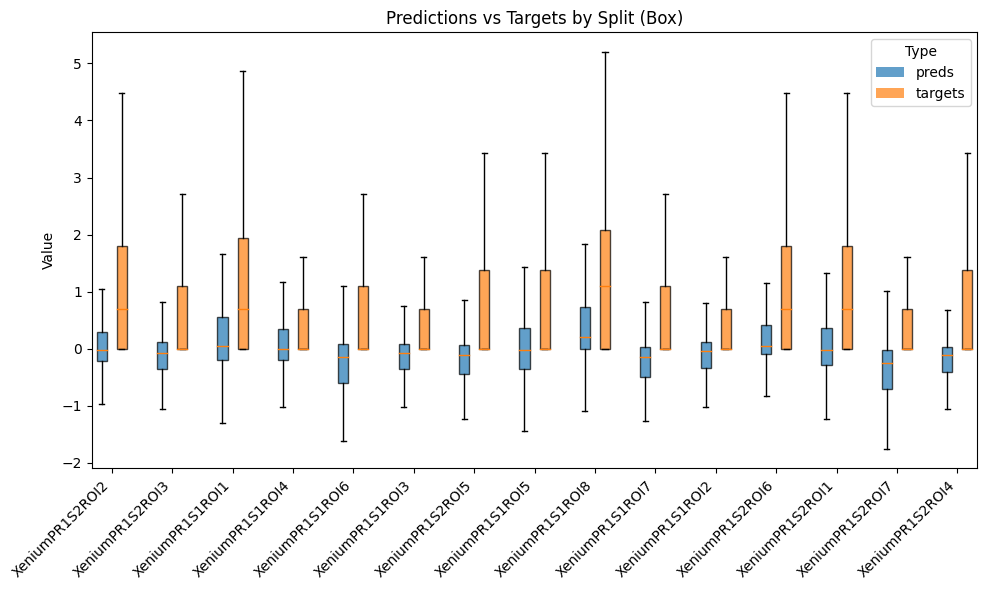

In [29]:
# Boxplot
plot_split_distributions(formatted_inference, plot_type="box")

# Violin plot (1 min)
# plot_split_distributions(formatted_inference, plot_type="violin")

# Load adata

In [30]:
data_dir = "/project/simmons_hts/kxu/hest/eval/data/XeniumPR1_segger/adata"
adata_list = []
sample_names = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".h5ad"):
        continue
    sample = os.path.splitext(fname)[0]
    fpath = os.path.join(data_dir, fname)
    adata = sc.read_h5ad(fpath)
    # store sample name in .obs (same value for all rows)
    adata.obs['sample_id'] = sample
    adata_list.append(adata)
    sample_names.append(sample)

print("Loaded and labeled samples:", sample_names)
print(f"Loaded {len(adata_list)} samples")
print(f"First sample shape: {adata_list[0].shape}")

Loaded and labeled samples: ['XeniumPR1S1ROI8', 'XeniumPR1S1ROI3', 'XeniumPR1S2ROI3', 'XeniumPR1S2ROI5', 'XeniumPR1S2ROI2', 'XeniumPR1S1ROI5', 'XeniumPR1S1ROI7', 'XeniumPR1S1ROI4', 'XeniumPR1S1ROI2', 'XeniumPR1S2ROI7', 'XeniumPR1S1ROI1', 'XeniumPR1S2ROI1', 'XeniumPR1S2ROI6', 'XeniumPR1S1ROI6', 'XeniumPR1S2ROI4']
Loaded 15 samples
First sample shape: (4687, 5161)


In [31]:
adata_list

[AnnData object with n_obs × n_vars = 4687 × 5161
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample_id'
     var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1611 × 5161
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample_id'
     var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropo

In [13]:
# assuming formatted_inference already loaded
patch_meta_map = attach_barcodes_to_formatted_inference_auto(
    formatted_inference,
    dataset_name="XeniumPR1_segger",  # only dataset name
    base_dir="/project/simmons_hts/kxu/hest/eval/data",
    subdir="patches",
    verbose=True
)

# Verify
key = next(iter(patch_meta_map))
print(f"\n{key}:")
print(patch_meta_map[key].head())
print("Pred index:", formatted_inference[key]["preds"].index[:5])

[read] XeniumPR1S2ROI2.h5: 2383 barcodes
[ok] XeniumPR1S2ROI2: attached 2383 barcodes
[read] XeniumPR1S2ROI3.h5: 1514 barcodes
[ok] XeniumPR1S2ROI3: attached 1514 barcodes
[read] XeniumPR1S1ROI1.h5: 684 barcodes
[ok] XeniumPR1S1ROI1: attached 684 barcodes
[read] XeniumPR1S1ROI4.h5: 1253 barcodes
[ok] XeniumPR1S1ROI4: attached 1253 barcodes
[read] XeniumPR1S1ROI6.h5: 2665 barcodes
[ok] XeniumPR1S1ROI6: attached 2665 barcodes
[read] XeniumPR1S1ROI3.h5: 1168 barcodes
[ok] XeniumPR1S1ROI3: attached 1168 barcodes
[read] XeniumPR1S2ROI5.h5: 892 barcodes
[ok] XeniumPR1S2ROI5: attached 892 barcodes
[read] XeniumPR1S1ROI5.h5: 893 barcodes
[ok] XeniumPR1S1ROI5: attached 893 barcodes
[read] XeniumPR1S1ROI8.h5: 3291 barcodes
[ok] XeniumPR1S1ROI8: attached 3291 barcodes
[read] XeniumPR1S1ROI7.h5: 2419 barcodes
[ok] XeniumPR1S1ROI7: attached 2419 barcodes
[read] XeniumPR1S1ROI2.h5: 482 barcodes
[ok] XeniumPR1S1ROI2: attached 482 barcodes
[read] XeniumPR1S2ROI6.h5: 1631 barcodes
[ok] XeniumPR1S2ROI6:

In [14]:
summary = add_formatted_inference_to_adata(adata_list, formatted_inference, fill_missing_with=np.nan, verbose=True)

[sanitize] ensuring adata_list[4] is h5ad-safe
[OK] sample 'XeniumPR1S2ROI2' -> adata[4] | matched_barcodes=2383/2383 | common_genes=5100 | method=match_by_obs_names | spots_with_pred=2383/4234 (56.28%)
[sanitize] ensuring adata_list[2] is h5ad-safe
[OK] sample 'XeniumPR1S2ROI3' -> adata[2] | matched_barcodes=1514/1514 | common_genes=5100 | method=match_by_obs_names | spots_with_pred=1514/2818 (53.73%)
[sanitize] ensuring adata_list[10] is h5ad-safe
[OK] sample 'XeniumPR1S1ROI1' -> adata[10] | matched_barcodes=684/684 | common_genes=5100 | method=match_by_obs_names | spots_with_pred=684/1094 (62.52%)
[sanitize] ensuring adata_list[7] is h5ad-safe
[OK] sample 'XeniumPR1S1ROI4' -> adata[7] | matched_barcodes=1253/1253 | common_genes=5100 | method=match_by_obs_names | spots_with_pred=1253/1868 (67.08%)
[sanitize] ensuring adata_list[13] is h5ad-safe
[OK] sample 'XeniumPR1S1ROI6' -> adata[13] | matched_barcodes=2665/2665 | common_genes=5100 | method=match_by_obs_names | spots_with_pred=266

In [15]:
save_adata_from_list(adata_list, RUN_ROOT, RUN)

[OK] Saved XeniumPR1S1ROI8 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S1ROI8.h5ad
[OK] Saved XeniumPR1S1ROI3 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S1ROI3.h5ad
[OK] Saved XeniumPR1S2ROI3 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S2ROI3.h5ad
[OK] Saved XeniumPR1S2ROI5 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S2ROI5.h5ad
[OK] Saved XeniumPR1S2ROI2 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S2ROI2.h5ad
[OK] Saved XeniumPR1S1ROI5 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S1ROI5.h5ad
[OK] Saved XeniumPR1S1ROI7 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pred/XeniumPR1S1ROI7.h5ad
[OK] Saved XeniumPR1S1ROI4 → /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/pr

## plot pred

In [16]:
cell_specific_genes = load_gene_list('XeniumPR1', 'cell_specific_genes.json')
cell_specific_genes[1:4]

Loaded cell_specific_genes.json for dataset 'XeniumPR1'


['CD4', 'PECAM1', 'BEST4']

In [17]:
results = save_spatial_pred_target_pdfs_for_adata_list(
    adata_list,
    cell_specific_genes,
    RUN_ROOT=RUN_ROOT,
    RUN=RUN,
    folder_name="cell_specific_genes",
    img_key="downscaled_fullres",
    pred_layer="pred",
    target_layer="target",
    genes_per_page=4,
    size=1.2,
    dpi=100,
    cmap=None,
    verbose=True
)

[START] Writing PDF for adata_list[0] (XeniumPR1S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf
[START] Writing PDF for adata_list[1] (XeniumPR1S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf
[START] Writing PDF for adata_list[2] (XeniumPR1S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3

In [18]:
conditional_genes = load_gene_list('XeniumPR1', 'conditional_genes.json')
conditional_genes[1:4]

Loaded conditional_genes.json for dataset 'XeniumPR1'


['REG1A', 'IL6', 'MUC5B']

In [19]:
results = save_spatial_pred_target_pdfs_for_adata_list(
    adata_list,
    conditional_genes,
    RUN_ROOT=RUN_ROOT,
    RUN=RUN,
    folder_name="conditional_genes",
    img_key="downscaled_fullres",
    pred_layer="pred",
    target_layer="target",
    genes_per_page=4,
    size=1.2,
    dpi=100,
    cmap=None,
    verbose=True
)

[START] Writing PDF for adata_list[0] (XeniumPR1S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S1ROI8.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S1ROI8.pdf
[START] Writing PDF for adata_list[1] (XeniumPR1S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S1ROI3.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S1ROI3.pdf
[START] Writing PDF for adata_list[2] (XeniumPR1S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S2ROI3.pdf (genes: 24)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/conditional_genes/XeniumPR1S2ROI3.pdf
[START]

# XeniumPR3

In [3]:
data_dir = "/project/simmons_hts/kxu/hest/eval/data/XeniumPR3/adata"
adata_list = []
sample_names = []

for fname in os.listdir(data_dir):
    if not fname.endswith(".h5ad"):
        continue
    sample = os.path.splitext(fname)[0]
    fpath = os.path.join(data_dir, fname)
    adata = sc.read_h5ad(fpath)
    # store sample name in .obs (same value for all rows)
    adata.obs['sample_id'] = sample
    adata_list.append(adata)
    sample_names.append(sample)

print("Loaded and labeled samples:", sample_names)
print(f"Loaded {len(adata_list)} samples")
print(f"First sample shape: {adata_list[0].shape}")

Loaded and labeled samples: ['XeniumPR3S1ROI7', 'XeniumPR3S1ROI5', 'XeniumPR3S1ROI4', 'XeniumPR3S1ROI2', 'XeniumPR3S1ROI6', 'XeniumPR3S1ROI1', 'XeniumPR3S1ROI3', 'XeniumPR3S1ROI8']
Loaded 8 samples
First sample shape: (1690, 5161)


# Development code (dont run)

In [ ]:
adata = adata_list[0]
%matplotlib inline 
sc.pl.spatial(adata,img_key="downscaled_fullres", color = 'total_counts',title=f"in_tissue spots",show=True)

/tmp/ipykernel_861551/3270156305.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata,img_key="downscaled_fullres", color = 'total_counts',title=f"in_tissue spots",show=True)


In [105]:
adata.obs['sample_id']

000x185    XeniumPR1S1ROI8
000x186    XeniumPR1S1ROI8
000x187    XeniumPR1S1ROI8
000x188    XeniumPR1S1ROI8
000x189    XeniumPR1S1ROI8
                ...       
057x229    XeniumPR1S1ROI8
057x230    XeniumPR1S1ROI8
057x231    XeniumPR1S1ROI8
057x232    XeniumPR1S1ROI8
057x233    XeniumPR1S1ROI8
Name: sample_id, Length: 4687, dtype: category
Categories (1, object): ['XeniumPR1S1ROI8']

In [48]:
formatted_inference['XeniumPR1S1ROI8']

{'preds':          A2ML1      AAMP      AAR2    AARSD1      ABAT     ABCA1     ABCA3  \
 0     0.047916  0.577047 -0.263145 -0.236633  0.199498 -0.055447 -0.277623   
 1     0.069674  1.387208  0.264742  0.207898  0.694126  0.949629 -0.056541   
 2     0.076444  1.059053 -0.079732 -0.096490  0.311142  0.020209 -0.254537   
 3     0.035192  0.214016 -0.570598 -0.441599  0.183509 -0.724473 -0.357092   
 4     0.067211 -0.163254 -0.351727 -0.231389 -0.082329 -0.248354 -0.195593   
 ...        ...       ...       ...       ...       ...       ...       ...   
 3286  0.053338  0.027492  0.108988  0.265677  0.225632 -0.046785  0.114326   
 3287  0.015896 -0.877562 -0.356886 -0.238915 -0.248874 -0.604370 -0.078648   
 3288  0.019623 -0.967415 -0.454202 -0.419355 -0.329338 -0.751155 -0.163657   
 3289  0.005652 -0.663913 -0.209062 -0.203371 -0.204840 -0.445858 -0.075009   
 3290  0.007454 -1.630395 -0.607500 -0.520095 -0.451655 -1.574311 -0.238413   
 
          ABCA4     ABCA7     ABCB1  ... 

In [49]:
adata.obs_names

Index(['000x185', '000x186', '000x187', '000x188', '000x189', '000x190',
       '000x191', '000x192', '000x193', '000x194',
       ...
       '057x224', '057x225', '057x226', '057x227', '057x228', '057x229',
       '057x230', '057x231', '057x232', '057x233'],
      dtype='object', length=4687)

# add prediction as a layer to adata

### Get barcode in prediction

In [118]:
tile_h5_path = "/project/simmons_hts/kxu/hest/eval/data/XeniumPR1_segger/patches/XeniumPR1S1ROI8.h5"

In [119]:
# inspect h5 file
with h5py.File(tile_h5_path, "r") as f:
    print("=== Top-level keys ===")
    print(list(f.keys()))

    # Inspect shapes and dtypes of the main datasets
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            print(f"{key:15s} shape={item.shape} dtype={item.dtype}")
        else:
            print(f"{key:15s} (Group)")

    # Show a few barcode examples if the dataset exists
    if 'barcode' in f:
        barcodes = f['barcode'][:10]  # first 10
        print("\nFirst 10 barcodes:")
        print([b.decode() if isinstance(b, bytes) else str(b) for b in barcodes])

    # Optionally check coords
    if 'coords' in f:
        coords = f['coords'][:5]
        print("\nFirst 5 coords:")
        print(coords)

    # Optionally check image patch shape
    if 'img' in f:
        img = f['img'][0]
        print("\nOne image patch shape:", img.shape, "dtype:", img.dtype)

=== Top-level keys ===
['barcode', 'coords', 'img']
barcode         shape=(3291, 1) dtype=object
coords          shape=(3291, 2) dtype=int64
img             shape=(3291, 224, 224, 3) dtype=uint8

First 10 barcodes:
["[b'002x160']", "[b'002x161']", "[b'002x162']", "[b'002x163']", "[b'003x159']", "[b'003x160']", "[b'003x161']", "[b'003x162']", "[b'003x163']", "[b'003x164']"]

First 5 coords:
[[4170  470]
 [4399  470]
 [4628  470]
 [4856  470]
 [3941  699]]

One image patch shape: (224, 224, 3) dtype: uint8


In [120]:
def _clean_barcode_raw(x):
    """
    Turn raw stored barcode entry into a clean string.
    Handles: bytes, numpy.bytes_, array([b'002x160']), strings like "[b'002x160']" etc.
    """
    # bytes -> decode
    if isinstance(x, (bytes, np.bytes_)):
        try:
            return x.decode()
        except Exception:
            return str(x)
    # numpy arrays or lists with one element
    if isinstance(x, (list, tuple, np.ndarray)):
        # flatten and take the first scalar element
        try:
            flat = np.array(x).flatten()
            if flat.size > 0:
                return _clean_barcode_raw(flat[0])
        except Exception:
            pass
        return str(x)
    # otherwise coerce to str and parse common patterns
    s = str(x).strip()
    # remove surrounding brackets like "['...']" or "[b'...']"
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1].strip()
    # if looks like b'....' or b"...."
    m = re.match(r"^b['\"](.+)['\"]$", s)
    if m:
        return m.group(1)
    # if quoted string '...' or "..."
    m2 = re.match(r"^['\"](.+)['\"]$", s)
    if m2:
        return m2.group(1)
    # fallback: remove weird characters commonly observed
    # remove leading b' or b"
    if s.startswith("b'") and s.endswith("'"):
        return s[2:-1]
    if s.startswith('b"') and s.endswith('"'):
        return s[2:-1]
    # final fallback: strip quotes and whitespace
    return s.strip().strip("'").strip('"')

with h5py.File(tile_h5_path, "r") as f:
    # read raw arrays
    raw_barcodes = f['barcode'][:]         # shape (N,1) in your file
    coords = f['coords'][:]                # shape (N,2)
    # safety checks
    n = len(raw_barcodes)
    assert coords.shape[0] == n, "barcode and coords length mismatch!"

# clean barcodes
cleaned = [_clean_barcode_raw(x) for x in raw_barcodes]

# If some entries still look like b'...' (rare), do one more pass to strip inner bytes markers
cleaned = [re.sub(r"^b['\"](.+)['\"]$", r"\1", s) for s in cleaned]

# build dataframe
df = pd.DataFrame({
    "barcode": cleaned,
    "coord_x": coords[:, 0].astype(int),
    "coord_y": coords[:, 1].astype(int)
})

# Quick preview
print(df.head(10))
print(df.shape)


   barcode  coord_x  coord_y
0  002x160     4170      470
1  002x161     4399      470
2  002x162     4628      470
3  002x163     4856      470
4  003x159     3941      699
5  003x160     4170      699
6  003x161     4399      699
7  003x162     4628      699
8  003x163     4856      699
9  003x164     5085      699
(3291, 3)


In [128]:
# ---- function to attach into an AnnData ----
def attach_patch_meta_to_adata(adata, patch_meta_df, barcode_colname='patch_barcode'):
    """
    Attach patch metadata (barcode, coord_x, coord_y) to adata.obs.
    adata.obs_names are expected to be barcodes (string). Works in-place.
    """
    # ensure types
    patch_meta_df = patch_meta_df.copy()
    patch_meta_df['barcode'] = patch_meta_df['barcode'].astype(str)

    obs_index = list(map(str, adata.obs_names))  # canonical obs names
    meta_by_barcode = patch_meta_df.set_index('barcode')

    # Prepare Series indexed by adata.obs_names (so assignment aligns)
    coord_x_s = pd.Series(index=obs_index, dtype="Float64")   # floatish to allow NaN, or use Int64 nullable
    coord_y_s = pd.Series(index=obs_index, dtype="Float64")
    barcode_s = pd.Series(index=obs_index, dtype="string")

    # Direct matches where obs_names are equal to patch barcodes
    common = meta_by_barcode.index.intersection(obs_index)
    if len(common) > 0:
        coord_x_s.loc[common] = meta_by_barcode.loc[common, 'coord_x'].astype("Int64")
        coord_y_s.loc[common] = meta_by_barcode.loc[common, 'coord_y'].astype("Int64")
        barcode_s.loc[common] = common
    print(f"[info] matched {len(common)} barcodes by obs_names")

    # For remaining barcodes, try matching to a barcode-like column in adata.obs
    remaining_meta = meta_by_barcode.index.difference(common)
    if len(remaining_meta) > 0:
        # find candidate columns
        candidate_cols = [c for c in adata.obs.columns if c.lower() in ('barcode','barcodes','cell_barcode','cell_id')]
        if candidate_cols:
            col = candidate_cols[0]
            # mapping from barcode-col value -> obs_name
            mapping = {str(v): obs for v, obs in zip(adata.obs[col].astype(str).values, obs_index)}
            matched2 = [b for b in remaining_meta if b in mapping]
            for b in matched2:
                obsn = mapping[b]
                coord_x_s.loc[obsn] = meta_by_barcode.loc[b, 'coord_x']
                coord_y_s.loc[obsn] = meta_by_barcode.loc[b, 'coord_y']
                barcode_s.loc[obsn] = b
            print(f"[info] matched {len(matched2)} barcodes by adata.obs['{col}']")
            remaining_meta = remaining_meta.difference(matched2)

    # Last resort: best-effort place first N patch rows into first N ad.obs rows (if you want)
    if len(remaining_meta) > 0:
        nplace = min(len(remaining_meta), len(obs_index))
        if nplace > 0:
            # place in the order they appear in patch_meta_df
            rem_list = [b for b in patch_meta_df['barcode'].tolist() if b in remaining_meta]
            rem_list = rem_list[:nplace]
            obs_slice = obs_index[:len(rem_list)]
            for b, obsn in zip(rem_list, obs_slice):
                coord_x_s.loc[obsn] = meta_by_barcode.loc[b, 'coord_x']
                coord_y_s.loc[obsn] = meta_by_barcode.loc[b, 'coord_y']
                barcode_s.loc[obsn] = b
            print(f"[info] best-effort assigned {len(rem_list)} remaining barcodes to first {len(rem_list)} obs rows")
            remaining_meta = remaining_meta.difference(rem_list)

    # Now assign into adata.obs (preserving NaNs for unmatched)
    adata.obs[barcode_colname] = barcode_s.values
    adata.obs['patch_x'] = coord_x_s.values
    adata.obs['patch_y'] = coord_y_s.values

    # reporting
    n_assigned = (~pd.isna(adata.obs[barcode_colname])).sum()
    print(f"[done] total assigned rows in adata.obs: {int(n_assigned)} / {adata.n_obs}")
    if len(remaining_meta) > 0:
        print(f"[warn] {len(remaining_meta)} patch barcodes were not matched to any adata.obs (they remain unassigned).")

    return adata

# ---- Example usage ----
adata = attach_patch_meta_to_adata(adata, patch_meta_df, barcode_colname='patch_barcode')
print(adata.obs[['patch_barcode','patch_x','patch_y']][1000:1010])


[info] matched 3291 barcodes by obs_names
[done] total assigned rows in adata.obs: 3291 / 4687
        patch_barcode  patch_x  patch_y
014x189       014x189  10805.0   3216.0
014x190       014x190  11034.0   3216.0
014x191       014x191  11263.0   3216.0
014x192       014x192  11492.0   3216.0
014x193       014x193  11721.0   3216.0
014x194       014x194  11949.0   3216.0
014x195       014x195  12178.0   3216.0
014x196       014x196  12407.0   3216.0
014x197       014x197  12636.0   3216.0
014x198       014x198  12865.0   3216.0


In [134]:
formatted_inference['XeniumPR1S1ROI8']['preds'].index = patch_meta_df['barcode']
formatted_inference['XeniumPR1S1ROI8']['targets'].index = patch_meta_df['barcode']

In [135]:
formatted_inference['XeniumPR1S1ROI8']

{'preds':             A2ML1      AAMP      AAR2    AARSD1      ABAT     ABCA1     ABCA3  \
 barcode                                                                         
 002x160  0.047916  0.577047 -0.263145 -0.236633  0.199498 -0.055447 -0.277623   
 002x161  0.069674  1.387208  0.264742  0.207898  0.694126  0.949629 -0.056541   
 002x162  0.076444  1.059053 -0.079732 -0.096490  0.311142  0.020209 -0.254537   
 002x163  0.035192  0.214016 -0.570598 -0.441599  0.183509 -0.724473 -0.357092   
 003x159  0.067211 -0.163254 -0.351727 -0.231389 -0.082329 -0.248354 -0.195593   
 ...           ...       ...       ...       ...       ...       ...       ...   
 055x179  0.053338  0.027492  0.108988  0.265677  0.225632 -0.046785  0.114326   
 055x180  0.015896 -0.877562 -0.356886 -0.238915 -0.248874 -0.604370 -0.078648   
 056x174  0.019623 -0.967415 -0.454202 -0.419355 -0.329338 -0.751155 -0.163657   
 056x175  0.005652 -0.663913 -0.209062 -0.203371 -0.204840 -0.445858 -0.075009   
 056x17

In [150]:
preds_df = formatted_inference['XeniumPR1S1ROI8']['preds']
targets_df = formatted_inference['XeniumPR1S1ROI8']['targets']

# canonical indexes and genes
ad_obs_names = list(map(str, adata.obs_names))
ad_var_names = list(map(str, adata.var_names))

# Which barcodes in preds are present in adata.obs_names?
matched_barcodes = sorted(list(set(preds_df.index).intersection(ad_obs_names)))
n_matched_barcodes = len(matched_barcodes)
n_total_barcodes = preds_df.shape[0]

# Genes in common between preds and adata
common_genes = [g for g in preds_df.columns if g in ad_var_names]
n_common_genes = len(common_genes)
if n_common_genes == 0:
    if verbose:
        print(f"[WARN] No common gene names between formatted_inference['{sample_key}'] and adata[{ad_idx}]. Skipping sample.")
    summary[sample_key] = {'matched': False, 'reason': 'no common genes'}

# Build full DataFrames (index = ad.obs_names, columns = ad.var_names), fill with fill_missing_with
# We'll create minimal memory overhead arrays instead of large pandas if desired, but pandas makes reindex easy
preds_on_ad = pd.DataFrame(None, index=ad_obs_names, columns=ad_var_names, dtype=float)
targets_on_ad = pd.DataFrame(None, index=ad_obs_names, columns=ad_var_names, dtype=float)

# Place matched barcodes rows and only common_genes columns
if n_matched_barcodes > 0:
    preds_on_ad.loc[matched_barcodes, common_genes] = preds_df.loc[matched_barcodes, common_genes].values
    targets_on_ad.loc[matched_barcodes, common_genes] = targets_df.loc[matched_barcodes, common_genes].values
    method = 'match_by_obs_names'
else:
    # If no direct barcode matches, try to match using barcode-like columns in adata.obs
    barcode_col = None
    for c in ['barcode', 'barcodes', 'cell_barcode', 'cell_id', 'patch_barcode']:
        if c in ad.obs.columns:
            barcode_col = c
            break
    if barcode_col is not None:
        mapping = {str(v): obs for v, obs in zip(ad.obs[barcode_col].astype(str).values, ad_obs_names)}
        matched_by_col = [b for b in preds_df.index if b in mapping]
        for b in matched_by_col:
            obsname = mapping[b]
            preds_on_ad.loc[obsname, common_genes] = preds_df.loc[b, common_genes].values
            targets_on_ad.loc[obsname, common_genes] = targets_df.loc[b, common_genes].values
        n_matched_barcodes = len(matched_by_col)
        method = f"match_by_obs['{barcode_col}']"
    else:
        # fallback: if preds rows == number of ad_obs, assign by order
        if preds_df.shape[0] == ad.n_obs:
            preds_on_ad.loc[ad_obs_names, common_genes] = preds_df.loc[:, common_genes].values
            targets_on_ad.loc[ad_obs_names, common_genes] = targets_df.loc[:, common_genes].values
            n_matched_barcodes = ad.n_obs
            method = 'assign_by_order'
        else:
            # last resort: place first N rows into first N obs rows
            nplace = min(preds_df.shape[0], ad.n_obs)
            obs_slice = ad_obs_names[:nplace]
            preds_on_ad.loc[obs_slice, common_genes] = preds_df.iloc[:nplace][common_genes].values
            targets_on_ad.loc[obs_slice, common_genes] = targets_df.iloc[:nplace][common_genes].values
            n_matched_barcodes = nplace
            method = 'best_effort_slice'

# convert to numpy float32 and assign to layers
pred_arr = preds_on_ad.values.astype(np.float32)
target_arr = targets_on_ad.values.astype(np.float32)

    #adata.layers = {}
adata.layers['pred'] = pred_arr
adata.layers['target'] = target_arr

In [151]:
adata

AnnData object with n_obs × n_vars = 4687 × 5161
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample_id', 'coord_x', 'coord_y', 'patch_barcode', 'patch_x', 'patch_y'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'pred', 'target'

In [165]:
# show layers for each adata that got matched
if hasattr(adata, 'layers') and 'pred' in adata.layers:
    print("pred shape", adata.layers['pred'].shape, "target shape", adata.layers['target'].shape)
    # print number of non-NaN cells for first gene
    gene_idx = 0
    print(" non-NaN cells for gene0:", np.sum(~np.isnan(adata.layers['pred'][:, gene_idx])))

pred shape (4687, 5161) target shape (4687, 5161)
 non-NaN cells for gene0: 3291


In [166]:
X_pred = adata.layers['pred']

print("Shape:", X_pred.shape, "(cells × genes)")

# mask NaNs
finite_mask = np.isfinite(X_pred)
mean_all = np.nanmean(X_pred)
std_all = np.nanstd(X_pred)
min_all = np.nanmin(X_pred)
max_all = np.nanmax(X_pred)

print(f"Global mean: {mean_all:.4f}")
print(f"Global std:  {std_all:.4f}")
print(f"Global min:  {min_all:.4f}")
print(f"Global max:  {max_all:.4f}")

# optional: fraction of NaN entries
frac_nan = 1 - finite_mask.sum() / X_pred.size
print(f"Fraction NaN: {frac_nan:.4%}")

Shape: (4687, 5161) (cells × genes)
Global mean: 0.4022
Global std:  0.6782
Global min:  -3.7452
Global max:  7.5416
Fraction NaN: 30.6144%


# plot pred

In [15]:
def plot_spatial_pred_target(
    adata,
    genes,
    img_key="downscaled_fullres",
    out_dir="./figures",
    pred_layer="pred",
    target_layer="target",
    show=True,
    save_png=True,
    dpi=150,
    fig_kwargs=None,
):
    import os
    import scanpy as sc
    import matplotlib.pyplot as plt
    import numpy as np

    os.makedirs(out_dir, exist_ok=True)
    fig_kwargs = {} if fig_kwargs is None else dict(fig_kwargs)

    if isinstance(genes, str):
        genes = [genes]

    for gene in genes:
        if gene not in adata.var_names:
            print(f"[WARN] {gene} not in adata.var_names, skipping.")
            continue
        gi = list(adata.var_names).index(gene)

        # create temporary obs columns for plotting
        adata.obs[f"pred_{gene}"] = adata.layers[pred_layer][:, gi]
        adata.obs[f"target_{gene}"] = adata.layers[target_layer][:, gi]

        # make plots side-by-side
        titles = [f"Pred {gene}", f"Target {gene}"]
        colors = [f"pred_{gene}", f"target_{gene}"]
        sc.pl.spatial(
            adata,
            img_key=img_key,
            color=colors,
            ncols=2,
            title=titles,
            show=False,
            **fig_kwargs,
        )

        # Save PNG file
        if save_png:
            out_path = os.path.join(out_dir, f"spatial_{gene}_pred_target.png")
            plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
            print(f"[OK] Saved plot for {gene} → {out_path}")

        if show:
            plt.show()
        else:
            plt.close()

        # cleanup
        del adata.obs[f"pred_{gene}"]
        del adata.obs[f"target_{gene}"]


In [184]:
plot_spatial_pred_target(
    adata,
    "AAMP",
    img_key="downscaled_fullres",
    fig_kwargs={'size': 1.5},
    save_png=True,
    show=False
)

/tmp/ipykernel_861551/1961502017.py:37: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


[OK] Saved plot for AAMP → ./figures/spatial_AAMP_pred_target.png


In [ ]:
plot_spatial_pred_target(
    adata_list[0],
    "AAMP",
    img_key="downscaled_fullres",
    fig_kwargs={'size': 1.5},
    save_png=True,
    show=True
)

/tmp/ipykernel_1370377/1961502017.py:37: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


[OK] Saved plot for AAMP → ./figures/spatial_AAMP_pred_target.png


In [20]:
cell_specific_genes = load_gene_list('XeniumPR1', 'cell_specific_genes.json')
cell_specific_genes[1:4]

Loaded cell_specific_genes.json for dataset 'XeniumPR1'


['CD4', 'PECAM1', 'BEST4']

In [24]:
results = save_spatial_pred_target_pdfs_for_adata_list(
    adata_list,
    cell_specific_genes[0:3],
    RUN_ROOT=RUN_ROOT,
    RUN=RUN,
    folder_name="cell_specific_genes",
    img_key="downscaled_fullres",
    pred_layer="pred",
    target_layer="target",
    genes_per_page=4,
    size=1.2,
    dpi=150,
    cmap=None,
    verbose=True
)

[START] Writing PDF for adata_list[0] (XeniumPR1S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf (genes: 3)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf
[START] Writing PDF for adata_list[1] (XeniumPR1S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf (genes: 3)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf
[START] Writing PDF for adata_list[2] (XeniumPR1S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3.pdf (genes: 3)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3.pd

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
import scanpy as sc
from scipy.sparse import issparse

# pearsonr fallback
try:
    from scipy.stats import pearsonr
except Exception:
    def pearsonr(a, b):
        mask = np.isfinite(a) & np.isfinite(b)
        if mask.sum() < 2:
            return (np.nan, np.nan)
        r = np.corrcoef(a[mask], b[mask])[0,1]
        return (float(r), np.nan)

def save_spatial_pred_target_pdfs_for_adata_list(
    adata_list,
    genes,
    RUN_ROOT,
    RUN,
    folder_name="cell_specific_genes",
    img_key="downscaled_fullres",
    pred_layer="pred",
    target_layer="target",
    genes_per_page=4,
    size=1.5,
    dpi=150,
    cmap=None,
    vmin=None,
    vmax=None,
    verbose=True,
):
    """
    For each AnnData in adata_list, create a PDF of spatial pred|target|raw plots for `genes`
    and save in RUN_ROOT/RUN/plots/pred/<folder_name>/<sample_name>.pdf

    Returns:
      results: dict mapping sample_name -> {"pdf_path": path_or_None, "summary": [per-gene dicts]}
    """
    outdir = os.path.join(RUN_ROOT, RUN, "plots", "pred", folder_name)
    os.makedirs(outdir, exist_ok=True)

    genes_list = list(genes)
    results = {}

    for i, ad in enumerate(adata_list):
        # sample name helper (same as earlier _safe_sample_name)
        if 'sample_id' in ad.obs.columns:
            sample_name = str(ad.obs['sample_id'].iat[0])
        elif 'sample' in ad.obs.columns:
            sample_name = str(ad.obs['sample'].iat[0])
        elif 'sample_id' in getattr(ad, 'uns', {}):
            sample_name = str(ad.uns['sample_id'])
        else:
            sample_name = f"adata_{i}"
        safe_name = "".join(c if c.isalnum() or c in ('-', '_') else "_" for c in sample_name)

        out_pdf = os.path.join(outdir, f"{safe_name}.pdf")

        # quick checks: pred/target layers exist?
        if pred_layer not in getattr(ad, "layers", {}):
            if verbose:
                print(f"[SKIP] adata_list[{i}] ({sample_name}): pred layer '{pred_layer}' not present.")
            results[sample_name] = {"pdf_path": None, "summary": None, "reason": f"missing layer {pred_layer}"}
            continue
        if target_layer not in getattr(ad, "layers", {}):
            if verbose:
                print(f"[SKIP] adata_list[{i}] ({sample_name}): target layer '{target_layer}' not present.")
            results[sample_name] = {"pdf_path": None, "summary": None, "reason": f"missing layer {target_layer}"}
            continue

        n_genes = len(genes_list)
        pages = int(math.ceil(n_genes / float(genes_per_page)))
        summary = []

        if verbose:
            print(f"[START] Writing PDF for adata_list[{i}] ({sample_name}) -> {out_pdf} (genes: {n_genes})")

        try:
            with PdfPages(out_pdf) as pp:
                gi = 0
                for page in range(pages):
                    # number of genes on this page
                    nrow = min(genes_per_page, n_genes - gi)

                    # grid: genes_per_page rows x 3 columns (pred | target | raw)
                    fig, axes = plt.subplots(genes_per_page, 3, figsize=(11, 8.5))  # wider page for 3 panels
                    if genes_per_page == 1:
                        axes = np.expand_dims(axes, 0)
                    fig.subplots_adjust(hspace=0.35, wspace=0.2)

                    for row in range(nrow):
                        gene = genes_list[gi]
                        gi += 1

                        pred_col = f"pred_{gene}"
                        target_col = f"target_{gene}"
                        raw_col = f"raw_{gene}"

                        ax_pred = axes[row, 0]
                        ax_target = axes[row, 1]
                        ax_raw = axes[row, 2]

                        if str(gene) not in list(map(str, ad.var_names)):
                            # gene missing: mark all three panels
                            ax_pred.text(0.5, 0.5, f"{gene} not in var_names", ha='center', va='center')
                            ax_pred.axis('off'); ax_target.axis('off'); ax_raw.axis('off')
                            summary.append({"gene": gene, "r": None, "n": 0})
                            continue

                        # compute gene index for ad.var
                        gi_idx = list(map(str, ad.var_names)).index(str(gene))

                        # fetch pred and target arrays (from layers)
                        pred_vals = np.array(ad.layers[pred_layer][:, gi_idx], dtype=float)
                        target_vals = np.array(ad.layers[target_layer][:, gi_idx], dtype=float)

                        # fetch raw expression: prefer ad.raw if available and contains gene, else ad.X
                        raw_vals = None
                        use_raw_name = None
                        if getattr(ad, 'raw', None) is not None:
                            # check var_names in raw
                            raw_var_names = list(map(str, ad.raw.var_names))
                            if str(gene) in raw_var_names:
                                gi_idx_raw = raw_var_names.index(str(gene))
                                raw_X = ad.raw.X
                                if issparse(raw_X):
                                    raw_vals = np.array(raw_X[:, gi_idx_raw].toarray()).ravel()
                                else:
                                    raw_vals = np.array(raw_X[:, gi_idx_raw]).ravel()
                                use_raw_name = 'raw (adata.raw.X)'
                        if raw_vals is None:
                            # fallback to ad.X
                            X = ad.X
                            if issparse(X):
                                raw_vals = np.array(X[:, gi_idx].toarray()).ravel()
                            else:
                                raw_vals = np.array(X[:, gi_idx]).ravel()
                            use_raw_name = 'X (adata.X)'

                        # attach temporary obs columns for scanpy plotting
                        # create copies of arrays as pandas-friendly
                        ad.obs[pred_col] = pred_vals
                        ad.obs[target_col] = target_vals
                        ad.obs[raw_col] = raw_vals

                        # compute stats between pred and target (as before)
                        mask = np.isfinite(pred_vals) & np.isfinite(target_vals)
                        n_valid = int(mask.sum())
                        if n_valid >= 2:
                            r_val, _ = pearsonr(pred_vals[mask], target_vals[mask])
                        else:
                            r_val = np.nan

                        # plot pred
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=FutureWarning)
                            try:
                                sc.pl.spatial(
                                    ad,
                                    img_key=img_key,
                                    color=[pred_col],
                                    ax=ax_pred,
                                    show=False,
                                    cmap=cmap,
                                    size=size
                                )
                            except Exception:
                                # fallback copy-fig approach
                                sc.pl.spatial(ad, img_key=img_key, color=[pred_col], show=False,
                                              cmap=cmap, size=size)
                                fig_src = plt.gcf()
                                ax_src = fig_src.axes[0]
                                for artist in ax_src.get_children():
                                    try:
                                        ax_pred.add_artist(artist)
                                    except Exception:
                                        pass
                                plt.close(fig_src)

                        # plot target
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=FutureWarning)
                            try:
                                sc.pl.spatial(
                                    ad,
                                    img_key=img_key,
                                    color=[target_col],
                                    ax=ax_target,
                                    show=False,
                                    cmap=cmap,
                                    size=size,
                                )
                            except Exception:
                                sc.pl.spatial(ad, img_key=img_key, color=[target_col], show=False,
                                              cmap=cmap, size=size)
                                fig_src = plt.gcf()
                                ax_src = fig_src.axes[0]
                                for artist in ax_src.get_children():
                                    try:
                                        ax_target.add_artist(artist)
                                    except Exception:
                                        pass
                                plt.close(fig_src)

                        # plot raw
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=FutureWarning)
                            try:
                                sc.pl.spatial(
                                    ad,
                                    img_key=img_key,
                                    color=[raw_col],
                                    ax=ax_raw,
                                    show=False,
                                    cmap=cmap,
                                    size=size,
                                )
                            except Exception:
                                sc.pl.spatial(ad, img_key=img_key, color=[raw_col], show=False,
                                              cmap=cmap, size=size)
                                fig_src = plt.gcf()
                                ax_src = fig_src.axes[0]
                                for artist in ax_src.get_children():
                                    try:
                                        ax_raw.add_artist(artist)
                                    except Exception:
                                        pass
                                plt.close(fig_src)

                        # annotate pred only
                        ann = f"r={r_val:.3f}  n={n_valid}" if np.isfinite(r_val) else f"r=NaN  n={n_valid}"
                        ax_pred.text(0.02, 0.95, ann, transform=ax_pred.transAxes,
                                     fontsize=9, color='white', va='top',
                                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

                        ax_pred.set_title(f"pred: {gene}", fontsize=9)
                        ax_target.set_title(f"target: {gene}", fontsize=9)
                        ax_raw.set_title(f"raw: {gene}", fontsize=9)

                        ax_pred.axis('off')
                        ax_target.axis('off')
                        ax_raw.axis('off')

                        # cleanup temporary obs cols
                        for c in (pred_col, target_col, raw_col):
                            if c in ad.obs.columns:
                                del ad.obs[c]

                        summary.append({"gene": gene, "r": float(r_val) if np.isfinite(r_val) else None, "n": n_valid})

                    # hide unused rows if any (axes shape: genes_per_page x 3)
                    total_rows = axes.shape[0]
                    if nrow < total_rows:
                        for rr in range(nrow, total_rows):
                            for cc in range(3):
                                axes[rr, cc].axis('off')

                    # save this page
                    pp.savefig(fig, dpi=dpi, bbox_inches='tight')
                    plt.close(fig)

            if verbose:
                print(f"[OK] Wrote PDF: {out_pdf}")

            results[sample_name] = {"pdf_path": out_pdf, "summary": summary, "reason": None}

        except Exception as e:
            # fail-safe: if anything goes wrong clean up partial file and continue
            try:
                if os.path.exists(out_pdf):
                    os.remove(out_pdf)
            except Exception:
                pass
            if verbose:
                print(f"[ERROR] Failed to create PDF for {sample_name}: {e}")
            results[sample_name] = {"pdf_path": None, "summary": None, "reason": str(e)}

    if verbose:
        print(f"[DONE] saved PDFs to {outdir}")
    return results

results = save_spatial_pred_target_pdfs_for_adata_list(
    adata_list,
    cell_specific_genes[,
    RUN_ROOT=RUN_ROOT,
    RUN=RUN,
    folder_name="cell_specific_genes",
    img_key="downscaled_fullres",
    pred_layer="pred",
    target_layer="target",
    genes_per_page=4,
    size=1.2,
    dpi=150,
    cmap=None,
    verbose=True
)

[START] Writing PDF for adata_list[0] (XeniumPR1S1ROI8) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI8.pdf
[START] Writing PDF for adata_list[1] (XeniumPR1S1ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S1ROI3.pdf
[START] Writing PDF for adata_list[2] (XeniumPR1S2ROI3) -> /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3.pdf (genes: 47)
[OK] Wrote PDF: /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-10-08-10-24-13/plots/pred/cell_specific_genes/XeniumPR1S2ROI3

### Develop a wrapper function to load prediction, save adata & plot

In [3]:
def add_inference_to_adata_and_plot(
    RUN,
    RUN_ROOT,
    dataset_name=None,
    gene_lists_to_plot=None,        # dict name-> (dataset, gene_list_name) or list of gene lists
    base_data_dir="/project/simmons_hts/kxu/hest/eval/data",
    patches_subdir="patches",
    adata_subdir_template="{}" ,    # for data dir if you build differently; default expects base_dir/dataset_name/adata
    plot_folder_root='plots/pred',
    pred_layer_name='pred',
    target_layer_name='target',
    genes_per_page=4,
    img_key="downscaled_fullres",
    size=1.2,
    dpi=120,
    cmap=None,
    verbose=True
):
    """
    High-level wrapper that:
      - extracts best model + inference for RUN
      - formats inference with gene list
      - reads dataset adata files into adata_list and attaches sample_id
      - attaches barcodes to formatted_inference (reads patch files under base_data_dir/dataset_name/patches)
      - writes pred/target arrays into each AnnData.layers (sanitises AnnData)
      - saves adata_list to disk under RUN_ROOT/RUN/<save_adata_subfolder>/
      - generates PDFs into RUN_ROOT/RUN/<plot_folder_root>/<gene_list_folder>/
    Returns a dict with summary, saved files, plot results.
    """

    # --------------- 1) extract best model + load inference ----------------
    if verbose: print("[step] extract best model corrs")
    best_model, dataset, df_corr = extract_best_model_gene_corrs(RUN)

    if verbose: print("[step] load best model inference and metadata")
    best_model_info, dataset_name_from_inference, inference_dumps, gene_list_name = load_best_model_inference(RUN)

    # If dataset_name specified as arg, prefer that; else use loaded dataset_name
    dataset_name = dataset_name or dataset_name_from_inference
    if verbose: print(f"[info] using dataset_name = {dataset_name}")

    if verbose: print("[step] load gene list used to format inference")
    gene_list = load_gene_list(dataset_name, gene_list_name)

    if verbose: print("[step] format inference with gene list")
    formatted_inference = format_inference_with_genes(inference_dumps, gene_list)

    if verbose: print("[step] remap split keys -> sample names using test splits")
    df_test_splits = get_test_splits(RUN)
    split_map = dict(zip(df_test_splits['split'], df_test_splits['test_sample']))
    # rename keys like 'split1' -> sample name
    for old_key in list(formatted_inference.keys()):
        if old_key.startswith('split'):
            try:
                split_num = int(old_key.replace('split',''))
                new_key = split_map.get(split_num, old_key)
            except Exception:
                new_key = old_key
            if new_key != old_key:
                formatted_inference[new_key] = formatted_inference.pop(old_key)

    # --------------- 2) load adata_list for dataset ----------------
    # dataset adata dir
    data_dir = os.path.join(base_data_dir, dataset_name, 'adata')
    if verbose: print(f"[step] loading adata files from {data_dir}")
    adata_list = []
    sample_names = []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".h5ad"):
            continue
        sample = os.path.splitext(fname)[0]
        fpath = os.path.join(data_dir, fname)
        if verbose: print(f"  loading {fpath}")
        adata = sc.read_h5ad(fpath)
        # store sample name in .obs for later saving and matching
        adata.obs['sample_id'] = sample
        adata_list.append(adata)
        sample_names.append(sample)

    # --------------- 3) attach patch barcodes to formatted_inference automatically -------------
    if verbose: print("[step] attach barcodes to formatted_inference using patches directory")
    patch_meta_map = attach_barcodes_to_formatted_inference_auto(
        formatted_inference,
        dataset_name=dataset_name,
        base_dir=base_data_dir,
        subdir=patches_subdir,
        verbose=verbose
    )

    # --------------- 4) add formatted_inference to adata layers ----------------
    if verbose: print("[step] writing preds/targets into adata.layers (with sanitisation)")
    summary = add_formatted_inference_to_adata(
        adata_list,
        formatted_inference,
        pred_layer_name=pred_layer_name,
        target_layer_name=target_layer_name,
        fill_missing_with=np.nan,
        overwrite_layers=True,
        verbose=verbose
    )

    # --------------- 5) save the adata list to RUN folder ----------------
    if verbose: print("[step] saving adata_list to disk")
    saved_paths = save_adata_from_list(adata_list, RUN_ROOT, RUN)

    # --------------- 6) optionally plot gene lists ----------------
    plot_results = {}
    if gene_lists_to_plot:
        # gene_lists_to_plot can be:
        #  - list of (dataset,gene_list_name) tuples
        #  - dict name-> (dataset, gene_list_name)
        #  - list of lists of gene names
        if isinstance(gene_lists_to_plot, dict):
            iter_items = gene_lists_to_plot.items()
        elif isinstance(gene_lists_to_plot, list) and len(gene_lists_to_plot) and isinstance(gene_lists_to_plot[0], (list,tuple)):
            # interpret as list of (name, (dataset, gene_list_name)) or list of name->list
            iter_items = []
            for item in gene_lists_to_plot:
                if isinstance(item, tuple) and len(item) == 2 and isinstance(item[1], (list,tuple)):
                    iter_items.append(item)
                else:
                    # fallback: treat as anonymous list of gene names and create default name
                    iter_items.append((f"gene_list_{len(iter_items)}", item))
        else:
            # single list of gene names
            iter_items = [("genes", gene_lists_to_plot)]

        for list_name, gene_spec in iter_items:
            # if gene_spec is tuple pointing to (dataset, gene_list_name) call load_gene_list
            if isinstance(gene_spec, (list,tuple)) and len(gene_spec) == 2 and isinstance(gene_spec[0], str) and isinstance(gene_spec[1], str):
                ds, glname = gene_spec
                genes_to_plot = load_gene_list(ds, glname)
            elif isinstance(gene_spec, (list,tuple)):
                genes_to_plot = list(gene_spec)
            elif isinstance(gene_spec, str):
                # assume this is a gene_list_name for dataset_name
                genes_to_plot = load_gene_list(dataset_name, gene_spec)
            else:
                raise ValueError("Unsupported gene_lists_to_plot format")

            if verbose: print(f"[plot] creating pdfs for gene list '{list_name}' with {len(genes_to_plot)} genes")
            out = save_spatial_pred_target_pdfs_for_adata_list(
                adata_list,
                genes_to_plot,
                RUN_ROOT=RUN_ROOT,
                RUN=RUN,
                folder_name=list_name,
                img_key=img_key,
                pred_layer=pred_layer_name,
                target_layer=target_layer_name,
                genes_per_page=genes_per_page,
                size=size,
                dpi=dpi,
                cmap=cmap,
                vmin=None,
                vmax=None,
                verbose=verbose
            )
            plot_results[list_name] = out

    # final assembled information
    result = {
        'RUN': RUN,
        'dataset_name': dataset_name,
        'formatted_inference_keys': list(formatted_inference.keys()),
        'add_inference_summary': summary,
        'saved_adata_paths': saved_paths,
        'patch_meta_map_keys': list(patch_meta_map.keys()),
        'plot_results': plot_results
    }

    if verbose: print("[DONE] pipeline finished")
    return result

[step] extract best model corrs
[extract] dataset=pilot encoder=gigapath pearson_mean=0.2633383803732042 std=0.012906135835042909
[step] load best model inference and metadata
Best model for dataset pilot:
encoder_name: gigapath
pearson_mean: 0.2633383803732042
pearson_std: 0.012906135835042909
Genes predicted from list: var_50genes.json
Loaded inference_dump.pkl from split0
Loaded inference_dump.pkl from split1
[info] using dataset_name = pilot
[step] load gene list used to format inference
Loaded var_50genes.json for dataset 'pilot'
[step] format inference with gene list
split0: preds shape (1232, 50), targets shape (1232, 50)
split1: preds shape (482, 50), targets shape (482, 50)
[step] remap split keys -> sample names using test splits
[step] loading adata files from /project/simmons_hts/kxu/hest/eval/data/pilot/adata
  loading /project/simmons_hts/kxu/hest/eval/data/pilot/adata/XeniumPR1S1ROI3.h5ad
  loading /project/simmons_hts/kxu/hest/eval/data/pilot/adata/XeniumPR1S1ROI2.h5ad


KeyboardInterrupt: 

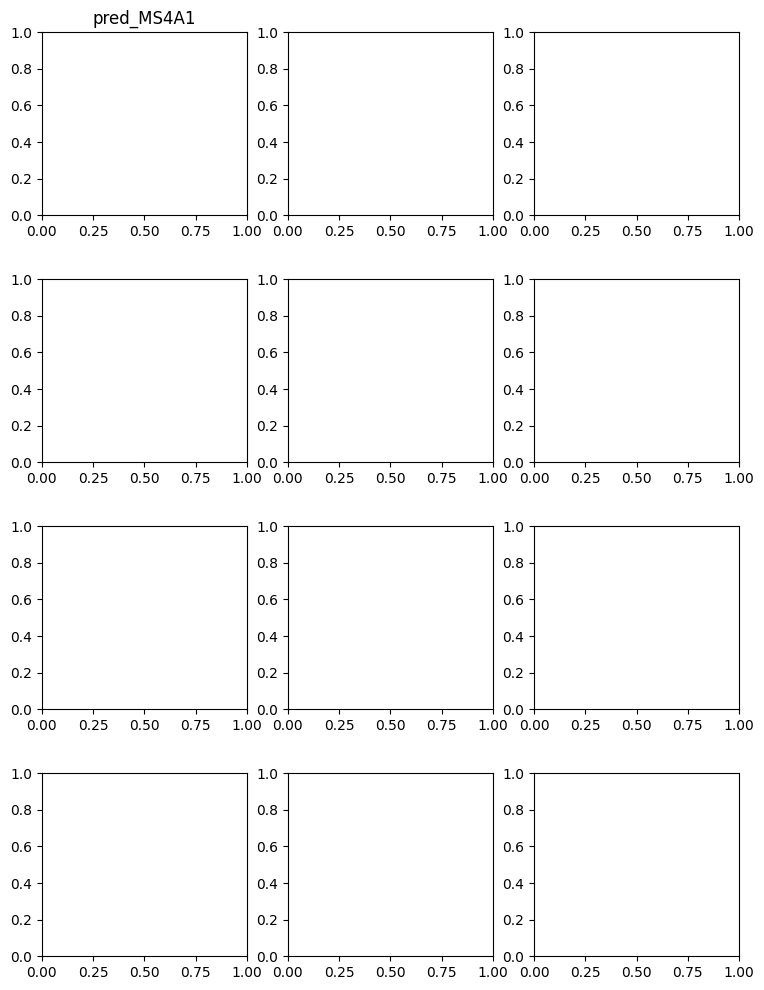

In [4]:
# don't run since pilot was using unfiltered adata so too many spots to plot
RUN = 'run_25-10-10-12-01-02'
RUN_ROOT = '/project/simmons_hts/kxu/hest/eval'   # or your run root path

results = run_inference_to_adata_and_plots(
    RUN=RUN,
    RUN_ROOT=RUN_ROOT,
    dataset_name=None,   # leave None to use the dataset inferred from load_best_model_inference(RUN)
    gene_lists_to_plot={
        "cell_specific_genes": ("XeniumPR1", "cell_specific_genes.json"),
        "conditional_genes": ("XeniumPR1", "conditional_genes.json")
    },
    base_data_dir="/project/simmons_hts/kxu/hest/eval/data",
    patches_subdir="patches",
    genes_per_page=4,
    img_key="downscaled_fullres",
    size=1.2,
    dpi=100,
    verbose=True
)